In [16]:
from __future__ import print_function
from __future__ import division
from __future__ import absolute_import

import argparse
import os
import time
import copy
import six
import sys
import torch
import numpy as np

import torchvision.models as models
import matplotlib.pyplot as plt
from torch.utils.data.dataloader import DataLoader
### tensorboard

from torch.utils.tensorboard import SummaryWriter
from torch.optim import lr_scheduler

writer = SummaryWriter('runs/experiment_prior')
#######
sys.path.append('/home/jbonato/Documents/cvpr_clvision_challenge/')
from core50.dataset import CORE50
from utils.train_test import train_net, test_multitask, preprocess_imgs
from utils.common import create_code_snapshot

######
import torch.nn as nn
import torch
import numpy

from DIM_model import *
from train import *
from PP_misc.loader import LoadDataset,data_split,data_split_Tr_CV,LoadFeatures
from PP_misc.transf import * 

In [17]:
device = torch.device('cuda:0')

In [18]:
dataset = CORE50(root='/home/jbonato/Documents/cvpr_clvision_challenge/core50/data/', scenario='ni',preload=True)

Loading data...
Loading paths...
Loading LUP...
Loading labels...
preparing CL benchmark...


In [19]:

test =  dataset.get_full_valid_set(reduced=True)


In [33]:
test[0][0][0].shape

(2249, 128, 128, 3)

In [5]:
i=0
writerDIM = SummaryWriter('runs/experiment_DIM'+str(i))
data,labels, t = dataset.next()

index_tr,index_cv,coreset = data_split(data.shape[0],777)

# adding eventual replay patterns to the current batch
if i == 0:
    ext_mem = [data[coreset], labels[coreset]]
    dataC = np.concatenate((data[index_tr], data[index_cv]),axis=0)
    labC = np.concatenate((labels[index_tr],labels[index_cv]),axis=0)
else:
    dataP = ext_mem[0]
    labP = ext_mem[1]

    ext_mem = [
        np.concatenate((data[coreset], ext_mem[0])),
        np.concatenate((labels[coreset], ext_mem[1]))]

    dataC = np.concatenate((data[index_tr], data[index_cv],dataP),axis=0)
    labC = np.concatenate((labels[index_tr],labels[index_cv],labP),axis=0)



Batch number: 0


In [10]:
load=False

In [11]:
print("----------- batch {0} -------------".format(i))
print("Task Label: ", t)
trC,cvC = data_split_Tr_CV(dataC.shape[0],777)

train_set = LoadDataset(dataC,labC,transform=None,indices=trC)
val_set = LoadDataset(dataC,labC,indices=cvC)
print('Training set: {0} \n Validation Set {0}'.format(train_set.__len__(),val_set.__len__()))
batch_size=32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
dataloaders = {'train':train_loader,'val':valid_loader}

if i ==0:        
    prior = False
    ep=80
    dim_model = DIM_model(batch_s=32,feature=True)   
    dim_model.to(device)
    classifierM = classifier(n_class=50)
    classifierM = classifierM.to(device)
    optimizerC = torch.optim.Adam(classifierM.parameters(),lr=0.0001)
    schedulerC = lr_scheduler.StepLR(optimizerC,step_size=40,gamma=0.1)
    writer = SummaryWriter('runs/experiment_C'+str(i))
else:
    prior = True
    ep=5

optimizer = torch.optim.Adam(dim_model.parameters(),lr=0.00001)
scheduler = lr_scheduler.StepLR(optimizer,step_size=40,gamma=0.1) #there is also MultiStepLR
tr_dict_enc = {'ep':ep,'writer':writerDIM,'best_loss':1e10,'t_board':True,'gamma':.5,'beta':.5,'Prior_Flag':prior,'discriminator':classifierM}    
tr_dict_cl = {'ep':30,'writer':writer,'best_loss':1e10,'t_board':True,'gamma':1}

if i==0 and load:
    print('Load DIM model weights first step')
    dim_model.load_state_dict(torch.load('/home/jbonato/Documents/cvpr_clvision_challenge/weights/weightsDIM_T0.pt'))
else:
    dim_model = trainEnc_MI(dim_model, optimizer, scheduler,dataloaders,device,tr_dict_enc)
    torch.save(dim_model.state_dict(), '/home/jbonato/Documents/cvpr_clvision_challenge/weights/weightsDIM_T'+str(i)+'.pt')



----------- batch 0 -------------
Task Label:  0
10792 2699
Epoch 0/79
----------
LR 1e-05
train: MI_loss: 0.861338, loss: 0.861338
val: MI_loss: -0.742366, loss: -0.742366
saving best model
0m 18s
Epoch 1/79
----------
LR 1e-05
train: MI_loss: -1.089838, loss: -1.089838
val: MI_loss: -1.046412, loss: -1.046412
saving best model
0m 18s
Epoch 2/79
----------
LR 1e-05
train: MI_loss: -1.224776, loss: -1.224776
val: MI_loss: -1.048018, loss: -1.048018
saving best model
0m 18s
Epoch 3/79
----------
LR 1e-05
train: MI_loss: -1.270146, loss: -1.270146
val: MI_loss: -1.180626, loss: -1.180626
saving best model
0m 18s
Epoch 4/79
----------
LR 1e-05
train: MI_loss: -1.302145, loss: -1.302145
val: MI_loss: -1.193701, loss: -1.193701
saving best model
0m 19s
Epoch 5/79
----------
LR 1e-05
train: MI_loss: -1.316260, loss: -1.316260
val: MI_loss: -1.230444, loss: -1.230444
saving best model
0m 18s
Epoch 6/79
----------
LR 1e-05
train: MI_loss: -1.323491, loss: -1.323491
val: MI_loss: -1.247478, los

In [15]:
from train_prior_disc import save_prior_dist
if i==0:
    dataTr,labTr = save_prior_dist(dim_model,train_loader,device)
    dataCv,labCv = save_prior_dist(dim_model,valid_loader,device)

    print(dataTr.shape,labTr.shape)

    train_set = LoadFeatures(dataTr,labTr)
    val_set = LoadFeatures(dataCv,labCv)
    batch_size=32

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
    dataloaderC = {'train':train_loader,'val':valid_loader}

    classifierM = train_classifier(classifierM, optimizerC, schedulerC,dataloaderC,device,tr_dict_cl)
    torch.save(classifierM.state_dict(), '/home/jbonato/Documents/cvpr_clvision_challenge/weights/weightsC_T'+str(i)+'.pt')

(10792, 64) (10792,)
Epoch 0/29
----------
LR 0.0001
train: loss: 3.774747, accuracy: 0.086816
val: loss: 3.232213, accuracy: 0.209091
saving best model
0m 1s
Epoch 1/29
----------
LR 0.0001
train: loss: 2.865636, accuracy: 0.319804
val: loss: 2.508738, accuracy: 0.447961
saving best model
0m 1s
Epoch 2/29
----------
LR 0.0001
train: loss: 2.263495, accuracy: 0.509246
val: loss: 2.017058, accuracy: 0.604512
saving best model
0m 1s
Epoch 3/29
----------
LR 0.0001
train: loss: 1.832836, accuracy: 0.636187
val: loss: 1.647243, accuracy: 0.697159
saving best model
0m 1s
Epoch 4/29
----------
LR 0.0001
train: loss: 1.511976, accuracy: 0.710152
val: loss: 1.384835, accuracy: 0.749699
saving best model
0m 1s
Epoch 5/29
----------
LR 0.0001
train: loss: 1.272974, accuracy: 0.760540
val: loss: 1.144657, accuracy: 0.784993
saving best model
0m 1s
Epoch 6/29
----------
LR 0.0001
train: loss: 1.086148, accuracy: 0.795581
val: loss: 1.010267, accuracy: 0.812533
saving best model
0m 1s
Epoch 7/29
--

In [5]:
data,labels,q = dataset.next()
dataT0 = data.copy()
labelsT0 = labels.copy()

n_dataset= data.shape[0]
debug = False
train_data_size = 800 if debug else int(n_dataset * 0.8)
test_data_size = 10 if debug else int(n_dataset * 0.1)
valid_data_size = 100 if debug else int(n_dataset - train_data_size-test_data_size)


perm = np.random.RandomState(777).permutation(n_dataset)

    
train_set = LoadDataset(data,labels,indices=perm[:train_data_size])
val_set = LoadDataset(data,labels,indices=perm[train_data_size:train_data_size+valid_data_size])
test_set = LoadDataset(data,labels,indices=perm[train_data_size+valid_data_size:train_data_size+valid_data_size+test_data_size])

batch_size=32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loaderqq = DataLoader(test_set, batch_size=batch_size, shuffle=False)

dataloaders = {'train':train_loader,
              'val':valid_loader}

Batch number: 0


In [6]:
import h5py
def save_prior_dist(encoder,dataloader,path,device):
    encoder.eval()
    data =None
    lab = None
    for inputs, labels in dataloader:
        torch.cuda.empty_cache()
        inputs = inputs.to(device)        
        _,_,pred = encoder(inputs)
        pred_l = pred.data.cpu().numpy()
        if data is None:
            data = pred_l
            lab = labels.data.cpu().numpy()
        else:
            data = np.concatenate((data,pred_l),axis=0)
            lab = np.concatenate((lab,labels.data.cpu().numpy()),axis=0)
    print(data.shape)
    with h5py.File(path,'w') as f:
        dset = f.create_dataset('data',data=data)
        dset = f.create_dataset('labels',data=lab)
        
        
# dim_model = DIM_model(batch_s=32,feature=True)
# dim_model.to(device)
# dim_model.load_state_dict(torch.load('/home/jbonato/Documents/cvpr_clvision_challenge/weights_T0.pt'))
# save_prior_dist(dim_model,train_loader,'/home/jbonato/Documents/cvpr_clvision_challenge/features/DataT0.hdf5',device)

In [8]:
#data,labels,q = dataset.next()

In [9]:
tr =Transform(affine=True, train=True,blur_ratio=0.5, cutout_ratio=0.5, ssr_ratio=0.5)

In [11]:
n_dataset= data.shape[0]
debug = False
train_data_size = 800 if debug else int(n_dataset * 0.8)
test_data_size = 10 if debug else int(n_dataset * 0.1)
valid_data_size = 100 if debug else int(n_dataset - train_data_size-test_data_size)


perm = np.random.RandomState(777).permutation(n_dataset)

    
train_set = LoadDataset(data,labels,transform=None,indices=perm[:train_data_size])
val_set = LoadDataset(data,labels,indices=perm[train_data_size:train_data_size+valid_data_size])
test_set = LoadDataset(data,labels,indices=perm[train_data_size+valid_data_size:train_data_size+valid_data_size+test_data_size])

batch_size=32#64
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

dataloaders = {'train':train_loader,
              'val':valid_loader}

In [12]:
dim_model = DIM_model(batch_s=32,feature=True)
dim_model.to(device)
discriminator = Prior_discriminator(n_input=64)
discriminator.to(device)

optimizer = torch.optim.Adam(dim_model.parameters(),lr=0.00001)
optimizerD = torch.optim.Adam(discriminator.parameters(),lr=0.0001)
scheduler = lr_scheduler.StepLR(optimizer,step_size=40,gamma=0.1) #there is also MultiStepLR
scheduler2 = lr_scheduler.StepLR(optimizerD,step_size=40,gamma=0.1)

tr_dict = {'ep':80,'writer':writer,'best_loss':1e10,'t_board':True,'gamma':.2,'beta':1,'Prior_Flag':False,
           'discriminator':discriminator,'optimizerD':optimizerD,
           'samples_path':'/home/jbonato/Documents/cvpr_clvision_challenge/features/DataT0',
          'scheduler2':scheduler2
          }

In [13]:
class sample_prior():
    def __init__(self,path,device):
        self.path = path
        self.device = device
        dset= h5py.File(path+'.hdf5','r') 
        prior_distrib =  np.asarray(dset['data'])
        self.prior_distrib = torch.as_tensor(prior_distrib, dtype = torch.float32,device=torch.device('cpu'))
        del prior_distrib
        
    def sample(self,size):
        index = np.random.choice(np.arange(self.prior_distrib.size(0)), size, replace=False)        
        sample_prior = self.prior_distrib[index,:]
        sample_prior = sample_prior.to(self.device)
        return sample_prior
    
def train(model, optimizer, scheduler,dataloaders,device,kwargs):
    """This funcion performs training of DIM local version without prior distrib. It can be wrapped into the DNN
       module as a class function  
    """
    nnLin = nn.Sigmoid()
    num_epochs=kwargs['ep']
    writer=kwargs['writer']
    best_loss=kwargs['best_loss']
    t_board=kwargs['t_board']
    gamma = kwargs['gamma']
    beta = kwargs['beta']
    use_prior = kwargs['Prior_Flag'] 
    discriminator = kwargs['discriminator'] 
    optimizerD = kwargs['optimizerD'] 
    samples_path = kwargs['samples_path']
    scheduler2 = kwargs['scheduler2']
    
    sampler = sample_prior(samples_path,device)
    gen_epoch = 0
    gen_epoch_l=0
    
    best_model_wts = copy.deepcopy(model.state_dict())
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        since = time.time()
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':    
                model.train()  # Set model to training mode
                discriminator.train()
            else:
                model.eval()   # Set model to evaluate mode
                discriminator.eval()

            metrics = defaultdict(float)
            epoch_samples = 0
            batch_num = 0
            for inputs, labels in dataloaders[phase]:
                
                torch.cuda.empty_cache()
                inputs = inputs.to(device)
                labels = labels.to(device)        
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):                    
                    E_phi,C_phi,A_phi = model(inputs)
                    A_phi = nnLin(A_phi)
                    #print('first', torch.cuda.max_memory_allocated(),torch.cuda.max_memory_cached())
                    loss = 0   
                    #we use jsd MI approx. since it is more stable eventually for other exp call compute dim loss
                    #function already implemented
                    loss = fenchel_dual_loss(C_phi, E_phi, measure='JSD')
                    metrics['loc_loss'] += loss.data.cpu().numpy()
                    #update_metrics(loss,metrics)
                    ################################## section for prior Loss
                    if use_prior:
                        #definition of X_Q (current samples) as features extracted by the encoder A_phi 
                        #in the paper there is also a sigmoid applied maybe it can be tested
                        X_P = sampler.sample(E_phi.size(0))
                        
                        loss*=beta
                        
                        if phase=='train':
                            train_disc(discriminator,X_P,A_phi.detach(),optimizerD,metrics,gradient_penalty=1.0)#discriminator,
                            Q_samples = discriminator(A_phi.detach())
                        else:
                            Q_samples = discriminator(A_phi)
                            metrics['disc val'] += Q_samples.data.cpu().numpy().mean()
                            
                        prior_loss = generator_loss(Q_samples, measure='GAN', loss_type='non-saturating')
                        metrics['prior_loss'] += prior_loss.data.cpu().numpy()
                        loss += gamma*prior_loss
                    metrics['loss'] += loss.data.cpu().numpy()
                    ################################## backward and tensorboard: othre quantities can be added
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        if batch_num % 20 == 0  and t_board:    
                            # ...log the running loss
                            writer.add_scalar('training loss',loss,epoch*gen_epoch+batch_num)
                    if phase == 'val' and t_board:
                        if batch_num % 10 == 0:    
                            # ...log the running loss
                            writer.add_scalar('Validation loss',loss,epoch*gen_epoch_l+batch_num)

                # statistics
                batch_num +=1
            if epoch ==0 and phase=='train':
                gen_epoch = batch_num
            if epoch ==0 and phase=='val':
                gen_epoch_l = batch_num
            if phase == 'train':
                
                avg = metrics['loss']/batch_num
                
                scheduler.step()#avg
                #scheduler2.step()
                
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
                for param_group in optimizerD.param_groups:
                    print("LR", param_group['lr'])
            ###ch
            
            print_metrics(metrics, batch_num, phase)
            # deep copy the model
            epoch_loss = metrics['loss']/batch_num
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                

                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since

        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)

    del best_model_wts
    return model

import numpy as np
import torch
import h5py

####libraries
from DIM.gradient_penalty import contrastive_gradient_penalty
from DIM.dim_loss import get_positive_expectation,get_negative_expectation

def train_disc(network,X_P,X_Q,optimizerD,metrics,gradient_penalty=1.0,measure='GAN'):

    '''
    Args:
        network: discriminator
        X_P: prior sample input.
        X_Q: current sample input.
        gradient_penalty: Gradient penalty amount.
        
    Legend:
        E_pos: prior expectation,
        Q_pos: current expectation,
        P_samples: prior samples,
        Q_samples: current samples
    '''

    nonlinearity = nn.Sigmoid()
    network.zero_grad() 
    P_samples = network(X_P.view(X_P.size(0),-1))
    Q_samples = network(X_Q.view(X_Q.size(0),-1))

    E_pos = get_positive_expectation(P_samples, measure)
    E_neg = get_negative_expectation(Q_samples, measure)
    difference = E_pos - E_neg

    gp_loss_P = contrastive_gradient_penalty(network, X_P, gradient_penalty)
    gp_loss_Q = contrastive_gradient_penalty(network, X_Q, gradient_penalty)
    gp_loss = 0.5 * (gp_loss_P + gp_loss_Q)
    
    #print(P_samples[:5],Q_samples[:5])
    metrics['E_P[D(x)]'] += P_samples.data.cpu().numpy().mean()
    metrics['E_Q[D(x)]'] += Q_samples.data.cpu().numpy().mean()
    
    lossD = -difference + gp_loss
    metrics['Disc_loss'] += lossD.data.cpu().numpy()
    
    lossD.backward()
    optimizerD.step()
    
    #return Q_samples #network,
    
class sample_prior():
    def __init__(self,path,device):
         self.path = path
#         self.device = device
#         dset= h5py.File(path+'.hdf5','r') 
#         prior_distrib =  np.asarray(dset['data'])
#         self.prior_distrib = torch.as_tensor(prior_distrib, dtype = torch.float32,device=torch.device('cpu'))
#         del prior_distrib
        
    def sample(self,size):
        #index = np.random.choice(np.arange(self.prior_distrib.size(0)), size, replace=False)        
        sample_prior = torch.as_tensor(np.random.random_sample((size,64)), dtype = torch.float32,device=torch.device(device))#self.prior_distrib[index,:]
        #sample_prior.to(device)
        return sample_prior


In [14]:
dim_model = train(dim_model, optimizer, scheduler,dataloaders,device,tr_dict)
torch.save(dim_model.state_dict(), '/home/jbonato/Documents/cvpr_clvision_challenge/weights_T0.pt')

Epoch 0/79
----------
LR 1e-05
LR 0.0001
train: loc_loss: 0.443648, loss: 0.443648
val: loc_loss: -0.934191, loss: -0.934191
saving best model
0m 20s
Epoch 1/79
----------
LR 1e-05
LR 0.0001
train: loc_loss: -1.157958, loss: -1.157958
val: loc_loss: -1.022615, loss: -1.022615
saving best model
0m 20s
Epoch 2/79
----------


KeyboardInterrupt: 

In [7]:
dim_model = DIM_model(batch_s=32,feature=True)
dim_model.to(device)
dim_model.load_state_dict(torch.load('/home/jbonato/Documents/cvpr_clvision_challenge/weights_T0.pt'))
save_prior_dist(dim_model,train_loader,'/home/jbonato/Documents/cvpr_clvision_challenge/features/DataT0.hdf5',device)

(11992, 64)


In [3]:
# dset= h5py.File('/home/jbonato/Documents/cvpr_clvision_challenge/features/DataT1.hdf5','r') 
# data1 =  np.asarray(dset['data'])
# lab1 = np.asarray(dset['labels'])
import h5py
dset= h5py.File('/home/jbonato/Documents/cvpr_clvision_challenge/features/DataT0.hdf5','r') 
data0 =  np.asarray(dset['data'])
lab0 = np.asarray(dset['labels'])

In [4]:
# n_dataset= data0.shape[0]
# debug = False
# test_data_size = 10 if debug else int(n_dataset * 0.1)
# perm = np.random.RandomState(777).permutation(n_dataset)

# data_inj = data0[perm[test_data_size:],:]
# lab_inj = lab0[perm[test_data_size:]]

# data_injT = data0[perm[:test_data_size],:]
# lab_injT = lab0[perm[:test_data_size]]
data0.shape

(11992, 64)

In [9]:
import numpy
import six
import torch
from torch.utils.data.dataset import Dataset
#import albumentations as A
import numpy as np
#import cv2
#from skimage.transform import AffineTransform, warp
import numpy as np
#import pandas as pd
import gc

class DatasetMixin(Dataset):

    def __init__(self, transform=None):
        self.transform = transform

    def __getitem__(self, index):
        """Returns an example or a sequence of examples."""
        if torch.is_tensor(index):
            index = index.tolist()
        if isinstance(index, slice):
            current, stop, step = index.indices(len(self))
            return [self.get_example_wrapper(i) for i in
                    six.moves.range(current, stop, step)]
        elif isinstance(index, list) or isinstance(index, numpy.ndarray):
            return [self.get_example_wrapper(i) for i in index]
        else:
            return self.get_example_wrapper(index)

    def __len__(self):
        """Returns the number of data points."""
        raise NotImplementedError

    def get_example_wrapper(self, i):
        """Wrapper of `get_example`, to apply `transform` if necessary"""
        example = self.get_example(i)
        if self.transform:
            example = self.transform(example)
        return example

    def get_example(self, i):
        """Returns the i-th example.

        Implementations should override it. It should raise :class:`IndexError`
        if the index is invalid.

        Args:
            i (int): The index of the example.

        Returns:
            The i-th example.

        """
        raise NotImplementedError
class LoadFeatures(DatasetMixin):
    def __init__(self, features, labels=None, transform=None, indices=None):
        super(LoadFeatures, self).__init__(transform=transform)
        self.images = features
        self.labels = labels
        if indices is None:
            indices = np.arange(len(features))
        self.indices = indices
        self.train = labels is not None

    def __len__(self):
        """return length of this dataset"""
        return len(self.indices)

    def get_example(self, i):
        """Return i-th data"""
        i = self.indices[i]
        x = self.images[i]    
        if self.train:
            y = self.labels[i]
            return x, y
        else:
            return x

In [10]:
# data1 = np.concatenate((data1,data_inj),axis=0)
# lab1 = np.concatenate((lab1,lab_inj),axis=0)
n_dataset= data0.shape[0]
debug = False
train_data_size = 800 if debug else int(n_dataset * 0.8)
test_data_size = 10 if debug else int(n_dataset * 0.1)
valid_data_size = 100 if debug else int(n_dataset - train_data_size-test_data_size)


perm = np.random.RandomState(777).permutation(n_dataset)

train_set = LoadFeatures(data0,lab0,indices=perm[:train_data_size])
val_set = LoadFeatures(data0,lab0,indices=perm[train_data_size:train_data_size+valid_data_size])
test_set = LoadFeatures(data0,lab0,indices=perm[train_data_size+valid_data_size:train_data_size+valid_data_size+test_data_size])
#test_set2 = LoadFeatures(data_injT,lab_injT)


batch_size=32

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
#test_loader2 = DataLoader(test_set2, batch_size=batch_size, shuffle=False)

dataloaders = {'train':train_loader,
              'val':valid_loader}

In [11]:
def init_weights(m):
    if type(m)== nn.Linear:
        nn.init.kaiming_uniform_(m.weight)

class classifier(nn.Module):
    def __init__(self,n_class):
        super().__init__()
        self.linear = nn.Sequential(
                nn.Linear(64, 256, bias=False),
                nn.BatchNorm1d(256),
                nn.ReLU(),
                nn.Linear(256, 128, bias=False),
                nn.BatchNorm1d(128),
                nn.ReLU(),
                nn.Linear(128, n_class)
            )
        self.linear.apply(init_weights)
        
    def forward(self,x):
        out = self.linear(x)
        return out
model_ft =classifier(n_class=50)
model_ft = model_ft.to(device)

In [12]:
def compute_loss(pred,y,metrics):
    """Compute accuracy and cross entropy loss for classifier"""
    
    loss = F.cross_entropy(pred,y)
    metrics['loss'] += loss.data.cpu().numpy()    
    pred_l = pred.data.cpu().numpy()
    metrics['accuracy'] +=np.sum(np.argmax(pred_l,axis=1)==y.data.cpu().numpy())/pred_l.shape[0] 
    return loss

def train_classifier(model, optimizer, scheduler,dataloaders,device,kwargs):
    """This funcion performs training of DIM local version without prior distrib. It can be wrapped into the DNN
       module as a class function  
    """
    
    num_epochs=kwargs['ep']
    writer=kwargs['writer']
    best_loss=kwargs['best_loss']
    t_board=kwargs['t_board']
    scale_loss = kwargs['gamma']
    
    gen_epoch = 0
    gen_epoch_l=0
    
    best_model_wts = copy.deepcopy(model.state_dict())
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        since = time.time()
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':    
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
            batch_num = 0
            for inputs, labels in dataloaders[phase]:
                labels = labels.type(torch.long)
                torch.cuda.empty_cache()
                inputs = inputs.to(device)
                labels = labels.to(device)        
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):                    
                    out = model(inputs)
                    #print('first', torch.cuda.max_memory_allocated(),torch.cuda.max_memory_cached())
                    loss = 0   
                    loss = compute_loss(out,labels,metrics)# fix this to have in dict accuracy and loss
                    # we need cross entropy for vlassificationd
                    #print(loss)
                   
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        if batch_num % 20 == 0  and t_board:    
                            #print(epoch*gen_epoch+batch_num)
                            # ...log the running loss
                            writer.add_scalar('training loss',loss,epoch*gen_epoch+batch_num)
                    if phase == 'val' and t_board:
                        if batch_num % 10 == 0:    
                            # ...log the running loss
                            writer.add_scalar('Validation loss',loss,epoch*gen_epoch_l+batch_num)

                # statistics
                batch_num +=1
            if epoch ==0 and phase=='train':
                gen_epoch = batch_num
            if epoch ==0 and phase=='val':
                gen_epoch_l = batch_num
            if phase == 'train':
                
                avg = metrics['loss']/batch_num
                
                scheduler.step()#avg

                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
            ###ch
            
            print_metrics(metrics, batch_num, phase)
            # deep copy the model
            epoch_loss = metrics['loss']/batch_num
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                

                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since

        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)

    del best_model_wts
    return model

In [13]:

writer = SummaryWriter('runs/experimentCL')
# model_ft.to(device)
optimizer = torch.optim.Adam(model_ft.parameters(),lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer,step_size=40,gamma=0.1) #there is also MultiStepLR
tr_dict = {'ep':30,'writer':writer,'best_loss':1e10,'t_board':True,'gamma':1}
model_ft = train_classifier(model_ft, optimizer, scheduler,dataloaders,device,tr_dict)

Epoch 0/29
----------
LR 0.001
train: loss: 2.132778, accuracy: 0.510183
val: loss: 0.985511, accuracy: 0.794408
saving best model
0m 1s
Epoch 1/29
----------
LR 0.001
train: loss: 0.749003, accuracy: 0.828633
val: loss: 0.536834, accuracy: 0.870888
saving best model
0m 1s
Epoch 2/29
----------
LR 0.001
train: loss: 0.418048, accuracy: 0.905925
val: loss: 0.363421, accuracy: 0.904605
saving best model
0m 1s
Epoch 3/29
----------
LR 0.001
train: loss: 0.270236, accuracy: 0.940879
val: loss: 0.275196, accuracy: 0.930921
saving best model
0m 1s
Epoch 4/29
----------
LR 0.001
train: loss: 0.192407, accuracy: 0.958246
val: loss: 0.239558, accuracy: 0.930921
saving best model
0m 1s
Epoch 5/29
----------
LR 0.001
train: loss: 0.135407, accuracy: 0.971221
val: loss: 0.216221, accuracy: 0.934211
saving best model
0m 1s
Epoch 6/29
----------
LR 0.001
train: loss: 0.105816, accuracy: 0.980700
val: loss: 0.188478, accuracy: 0.945724
saving best model
0m 1s
Epoch 7/29
----------
LR 0.001
train: los

In [14]:
def compute_loss(pred,y,metrics):
    """Compute accuracy and cross entropy loss for classifier"""
    
    loss = F.cross_entropy(pred,y)
    metrics['lossS'] += loss.data.cpu().numpy()    
    pred_l = pred.data.cpu().numpy()
    metrics['accuracyS'] +=np.sum(np.argmax(pred_l,axis=1)==y.data.cpu().numpy())/pred_l.shape[0] 
    return loss

def trainN(model, optimizer, scheduler,dataloaders,device,kwargs):
    """This funcion performs training of DIM local version without prior distrib. It can be wrapped into the DNN
       module as a class function  
    """
    nnLin = nn.Sigmoid()
    num_epochs=kwargs['ep']
    writer=kwargs['writer']
    best_loss=kwargs['best_loss']
    t_board=kwargs['t_board']
    gamma = kwargs['gamma']
    beta = kwargs['beta']
    use_prior = kwargs['Prior_Flag'] 
    discriminator = kwargs['discriminator'] 
    optimizerD = kwargs['optimizerD'] 
    samples_path = kwargs['samples_path']
    scheduler2 = kwargs['scheduler2']
    
    sampler = sample_prior(samples_path,device)
    gen_epoch = 0
    gen_epoch_l=0
    
    best_model_wts = copy.deepcopy(model.state_dict())
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        since = time.time()
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':    
                model.train()  # Set model to training mode
                discriminator.requires_grad_(False)
            else:
                model.eval()   # Set model to evaluate mode
                #discriminator.eval()
                discriminator.requires_grad_(False)

            metrics = defaultdict(float)
            epoch_samples = 0
            batch_num = 0
            for inputs, labels in dataloaders[phase]:
                labels = labels.type(torch.long)
                torch.cuda.empty_cache()
                inputs = inputs.to(device)
                labels = labels.to(device)        
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):                    
                    E_phi,C_phi,A_phi = model(inputs)
                    #A_phi = nnLin(A_phi)
                    #print('first', torch.cuda.max_memory_allocated(),torch.cuda.max_memory_cached())
                    loss = 0   
                    #we use jsd MI approx. since it is more stable eventually for other exp call compute dim loss
                    #function already implemented
                    loss = fenchel_dual_loss(C_phi, E_phi, measure='JSD')
                    metrics['loc_loss'] += loss.data.cpu().numpy()
                    #update_metrics(loss,metrics)
                    ################################## section for prior Loss
                    Q_samples = discriminator(A_phi)
                    disc_loss =compute_loss(Q_samples,labels,metrics)
                    loss += gamma*disc_loss
                    metrics['loss'] += loss.data.cpu().numpy()
                    ################################## backward and tensorboard: othre quantities can be added
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        if batch_num % 20 == 0  and t_board:    
                            # ...log the running loss
                            writer.add_scalar('training loss',loss,epoch*gen_epoch+batch_num)
                    if phase == 'val' and t_board:
                        if batch_num % 10 == 0:    
                            # ...log the running loss
                            writer.add_scalar('Validation loss',loss,epoch*gen_epoch_l+batch_num)

                # statistics
                batch_num +=1
            if epoch ==0 and phase=='train':
                gen_epoch = batch_num
            if epoch ==0 and phase=='val':
                gen_epoch_l = batch_num
            if phase == 'train':
                
                avg = metrics['loss']/batch_num
                
                scheduler.step()#avg
                #scheduler2.step()
                
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
                for param_group in optimizerD.param_groups:
                    print("LR", param_group['lr'])
            ###ch
            
            print_metrics(metrics, batch_num, phase)
            # deep copy the model
            epoch_loss = metrics['loss']/batch_num
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                

                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since

        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)

    del best_model_wts
    return model

In [23]:
dim_model = DIM_model(batch_s=32,feature=True)
dim_model.to(device)
dim_model.load_state_dict(torch.load('/home/jbonato/Documents/cvpr_clvision_challenge/weights_T0.pt'))
discriminator = Prior_discriminator(n_input=64)
discriminator.to(device)
for child in model_ft.children():
    for param in child.parameters():
        param.requires_grad = False
optimizer = torch.optim.Adam(dim_model.parameters(),lr=0.00001)
optimizerD = torch.optim.Adam(discriminator.parameters(),lr=0.0001)
scheduler = lr_scheduler.StepLR(optimizer,step_size=40,gamma=0.1) #there is also MultiStepLR
scheduler2 = lr_scheduler.StepLR(optimizerD,step_size=40,gamma=0.1)


tr_dict = {'ep':20,'writer':writer,'best_loss':1e10,'t_board':True,'gamma':.5,'beta':.5,'Prior_Flag':False,
           'discriminator':model_ft,'optimizerD':optimizerD,
           'samples_path':'/home/jbonato/Documents/cvpr_clvision_challenge/features/DataT0',
          'scheduler2':scheduler2
          }

data,labels,_ = dataset.next()
n_dataset= data.shape[0]
debug = False
train_data_size = 800 if debug else int(n_dataset * 0.8)
test_data_size = 10 if debug else int(n_dataset * 0.1)
valid_data_size = 100 if debug else int(n_dataset - train_data_size-test_data_size)


perm = np.random.RandomState(777).permutation(n_dataset)

    
train_set = LoadDataset(data,labels,transform=None,indices=perm[:train_data_size])
val_set = LoadDataset(data,labels,indices=perm[train_data_size:train_data_size+valid_data_size])
test_set = LoadDataset(data,labels,indices=perm[train_data_size+valid_data_size:train_data_size+valid_data_size+test_data_size])

batch_size=32#64
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

dataloaders = {'train':train_loader,
              'val':valid_loader}
dim_model = trainN(dim_model, optimizer, scheduler,dataloaders,device,tr_dict)

Batch number: 3
Epoch 0/19
----------
LR 1e-05
LR 0.0001
train: loc_loss: -1.341025, lossS: 1.567571, accuracyS: 0.683657, loss: -0.557239
val: loc_loss: -1.239399, lossS: 0.396249, accuracyS: 0.881364, loss: -1.041275
saving best model
0m 24s
Epoch 1/19
----------
LR 1e-05
LR 0.0001
train: loc_loss: -1.350467, lossS: 0.243690, accuracyS: 0.925469, loss: -1.228621
val: loc_loss: -1.319422, lossS: 0.138940, accuracyS: 0.951938, loss: -1.249952
saving best model
0m 25s
Epoch 2/19
----------
LR 1e-05
LR 0.0001
train: loc_loss: -1.354703, lossS: 0.090642, accuracyS: 0.970068, loss: -1.309382
val: loc_loss: -1.318819, lossS: 0.082267, accuracyS: 0.970460, loss: -1.277685
saving best model
0m 23s
Epoch 3/19
----------


KeyboardInterrupt: 

In [16]:

torch.save(dim_model.state_dict(), '/home/jbonato/Documents/cvpr_clvision_challenge/weights_T1.pt')

In [24]:
score= []
model_ft.eval()
for inputs, labels in test_loaderqq:
    torch.cuda.empty_cache()
    inputs = inputs.to(device)
    labels = labels.to(device) 
    _,_,ww =dim_model(inputs)
    pred = model_ft(ww)
    pred_l = pred.data.cpu().numpy()
    score.append(np.sum(np.argmax(pred_l,axis=1)==labels.data.cpu().numpy())/pred_l.shape[0])
np.asarray(score).mean()

0.9200896375098503

In [25]:
score= []
model_ft.eval()
for inputs, labels in test_loader:
    torch.cuda.empty_cache()
    inputs = inputs.to(device)
    labels = labels.to(device) 
    _,_,ww =dim_model(inputs)
    pred = model_ft(ww)
    pred_l = pred.data.cpu().numpy()
    score.append(np.sum(np.argmax(pred_l,axis=1)==labels.data.cpu().numpy())/pred_l.shape[0])
np.asarray(score).mean()

0.9593183609141056

0.9513706140350876

In [7]:
print(data.shape,labels.shape)

(14995, 128, 128, 3) (14995,)


In [8]:
n_dataset= data.shape[0]
debug = False
train_data_size = 800 if debug else int(n_dataset * 0.7)
test_data_size = 10 if debug else int(n_dataset * 0.1)
valid_data_size = 100 if debug else int(n_dataset - train_data_size-test_data_size)
print(train_data_size/n_dataset,valid_data_size/n_dataset)

perm = np.random.RandomState(777).permutation(n_dataset)

    
train_set = LoadDataset(data,labels,indices=perm[:train_data_size])
val_set = LoadDataset(data,labels,indices=perm[train_data_size:train_data_size+valid_data_size])
test_set = LoadDataset(data,labels,indices=perm[train_data_size+valid_data_size:train_data_size+valid_data_size+test_data_size])
test_setT0 = LoadDataset(dataT0,labelsT0)

batch_size=32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
test_loaderT0 = DataLoader(test_setT0, batch_size=batch_size, shuffle=False)

dataloaders = {'train':train_loader,
              'val':valid_loader}


0.6999666555518507 0.20006668889629878


(3, 128, 128) 4.0
[0.15904643 0.30904883 0.4041434 ]


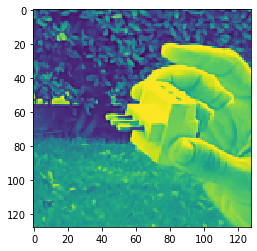

In [9]:
q,l =train_set.get_example(0)
print(q.shape,l)
print(np.mean(q.reshape(3,-1),axis=1))
plt.imshow(q[0,::])

In [10]:
# dim_model.to(device)
# dim_model = train(dim_model, optimizer, scheduler,dataloaders,device,tr_dict)
# torch.save(dim_model.state_dict(), '/home/jbonato/Documents/cvpr_clvision_challenge/weights_T0.pt')

In [11]:
def init_weights(m):
    if type(m)== nn.Linear:
        nn.init.kaiming_uniform_(m.weight)

class classifier(nn.Module):
    def __init__(self,n_class,w_path):
        super().__init__()
        mod_tr =  DIM_model()
        mod_tr.load_state_dict(torch.load(w_path))
        self.extractor = mod_tr.encoder
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        
        #fix to have a in feature automatic
#         fake_in = torch.ones([2,3,128,128])
#         out1,out2 = self.extractor(fake_in)
#         print(out1.size(),out2.size())
        ### da inserire il decodel lineare 
        ### inizializzare i pesi 
        self.linear = nn.Sequential(
                nn.Linear(512, 256, bias=False),
                nn.BatchNorm1d(256),
                nn.ReLU(),
                nn.Linear(256, 128, bias=False),
                nn.BatchNorm1d(128),
                nn.ReLU(),
                nn.Linear(128, n_class)
            )
        self.linear.apply(init_weights)
        
    def forward(self,x):
        C_phi = self.extractor(x)
        C_phi = self.avgpool(C_phi)
        
        C_phi = C_phi.view(C_phi.size(0),-1)
        #print(C_phi.size())
        out = self.linear(C_phi)
        return out

model_ft = classifier(n_class=50,w_path='/home/jbonato/Documents/cvpr_clvision_challenge/weights_T1.pt')
cnt=0
for child in model_ft.children():
    if cnt ==0:
        for param in child.parameters():
            param.requires_grad = False
    cnt+=1
    
# fake_in = torch.ones([2,3,128,128])
# res1 = model_ft(fake_in)
# print(res1.size())
model_ft = model_ft.to(device)

In [12]:
def compute_loss(pred,y,metrics):
    """Compute accuracy and cross entropy loss for classifier"""
    
    loss = F.cross_entropy(pred,y)
    metrics['loss'] += loss.data.cpu().numpy()    
    pred_l = pred.data.cpu().numpy()
    metrics['accuracy'] +=np.sum(np.argmax(pred_l,axis=1)==y.data.cpu().numpy())/pred_l.shape[0] 
    return loss

def train_classifier(model, optimizer, scheduler,dataloaders,device,kwargs):
    """This funcion performs training of DIM local version without prior distrib. It can be wrapped into the DNN
       module as a class function  
    """
    
    num_epochs=kwargs['ep']
    writer=kwargs['writer']
    best_loss=kwargs['best_loss']
    t_board=kwargs['t_board']
    scale_loss = kwargs['gamma']
    
    gen_epoch = 0
    gen_epoch_l=0
    
    best_model_wts = copy.deepcopy(model.state_dict())
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        since = time.time()
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':    
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
            batch_num = 0
            for inputs, labels in dataloaders[phase]:
                labels = labels.type(torch.long)
                torch.cuda.empty_cache()
                inputs = inputs.to(device)
                labels = labels.to(device)        
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):                    
                    out = model(inputs)
                    #print('first', torch.cuda.max_memory_allocated(),torch.cuda.max_memory_cached())
                    loss = 0   
                    loss = compute_loss(out,labels,metrics)# fix this to have in dict accuracy and loss
                    # we need cross entropy for vlassificationd
                    #print(loss)
                   
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        if batch_num % 20 == 0  and t_board:    
                            #print(epoch*gen_epoch+batch_num)
                            # ...log the running loss
                            writer.add_scalar('training loss',loss,epoch*gen_epoch+batch_num)
                    if phase == 'val' and t_board:
                        if batch_num % 10 == 0:    
                            # ...log the running loss
                            writer.add_scalar('Validation loss',loss,epoch*gen_epoch_l+batch_num)

                # statistics
                batch_num +=1
            if epoch ==0 and phase=='train':
                gen_epoch = batch_num
            if epoch ==0 and phase=='val':
                gen_epoch_l = batch_num
            if phase == 'train':
                
                avg = metrics['loss']/batch_num
                
                scheduler.step()#avg

                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
            ###ch
            
            print_metrics(metrics, batch_num, phase)
            # deep copy the model
            epoch_loss = metrics['loss']/batch_num
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                

                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since

        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)

    del best_model_wts
    return model

In [13]:
writer = SummaryWriter('runs/experimentCL')
# model_ft.to(device)
optimizer = torch.optim.Adam(model_ft.parameters(),lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer,step_size=40,gamma=0.1) #there is also MultiStepLR
tr_dict = {'ep':30,'writer':writer,'best_loss':1e10,'t_board':True,'gamma':1}
model_ft = train_classifier(model_ft, optimizer, scheduler,dataloaders,device,tr_dict)


Epoch 0/29
----------
LR 0.001
train: loss: 1.240689, accuracy: 0.754668
val: loss: 0.259565, accuracy: 0.966423
saving best model
0m 8s
Epoch 1/29
----------
LR 0.001
train: loss: 0.191811, accuracy: 0.972752
val: loss: 0.090407, accuracy: 0.986037
saving best model
0m 8s
Epoch 2/29
----------
LR 0.001
train: loss: 0.074673, accuracy: 0.990758
val: loss: 0.045342, accuracy: 0.993351
saving best model
0m 8s
Epoch 3/29
----------
LR 0.001
train: loss: 0.042783, accuracy: 0.995617
val: loss: 0.030442, accuracy: 0.995346
saving best model
0m 8s
Epoch 4/29
----------
LR 0.001
train: loss: 0.030676, accuracy: 0.996189
val: loss: 0.028684, accuracy: 0.994016
saving best model
0m 8s
Epoch 5/29
----------
LR 0.001
train: loss: 0.023925, accuracy: 0.997332
val: loss: 0.018243, accuracy: 0.996676
saving best model
0m 8s
Epoch 6/29
----------
LR 0.001
train: loss: 0.020181, accuracy: 0.997809
val: loss: 0.024665, accuracy: 0.995900
0m 8s
Epoch 7/29
----------
LR 0.001
train: loss: 0.028043, accur

KeyboardInterrupt: 

In [14]:
score= []
model_ft.eval()
for inputs, labels in test_loader:
    torch.cuda.empty_cache()
    inputs = inputs.to(device)
    labels = labels.to(device) 
    pred = model_ft(inputs)
    pred_l = pred.data.cpu().numpy()
    score.append(np.sum(np.argmax(pred_l,axis=1)==labels.data.cpu().numpy())/pred_l.shape[0])

In [15]:
np.asarray(score).mean()

0.9940159574468085

In [18]:
score= []
model_ft.eval()
for inputs, labels in test_loaderT0:
    torch.cuda.empty_cache()
    inputs = inputs.to(device)
    labels = labels.to(device) 
    pred = model_ft(inputs)
    pred_l = pred.data.cpu().numpy()
    score.append(np.sum(np.argmax(pred_l,axis=1)==labels.data.cpu().numpy())/pred_l.shape[0])


In [19]:
np.asarray(score).mean()

0.32836709310589907

In [2]:
# for i, train_batch in enumerate(dataset):
#     train_x, train_y, t = train_batch
#     print(train_x.shape,train_y.shape,t)
#     print(np.unique(train_y))

In [42]:
import matplotlib.pyplot as plt
train_x[100,0,0,:]

array([187., 178., 166.], dtype=float32)

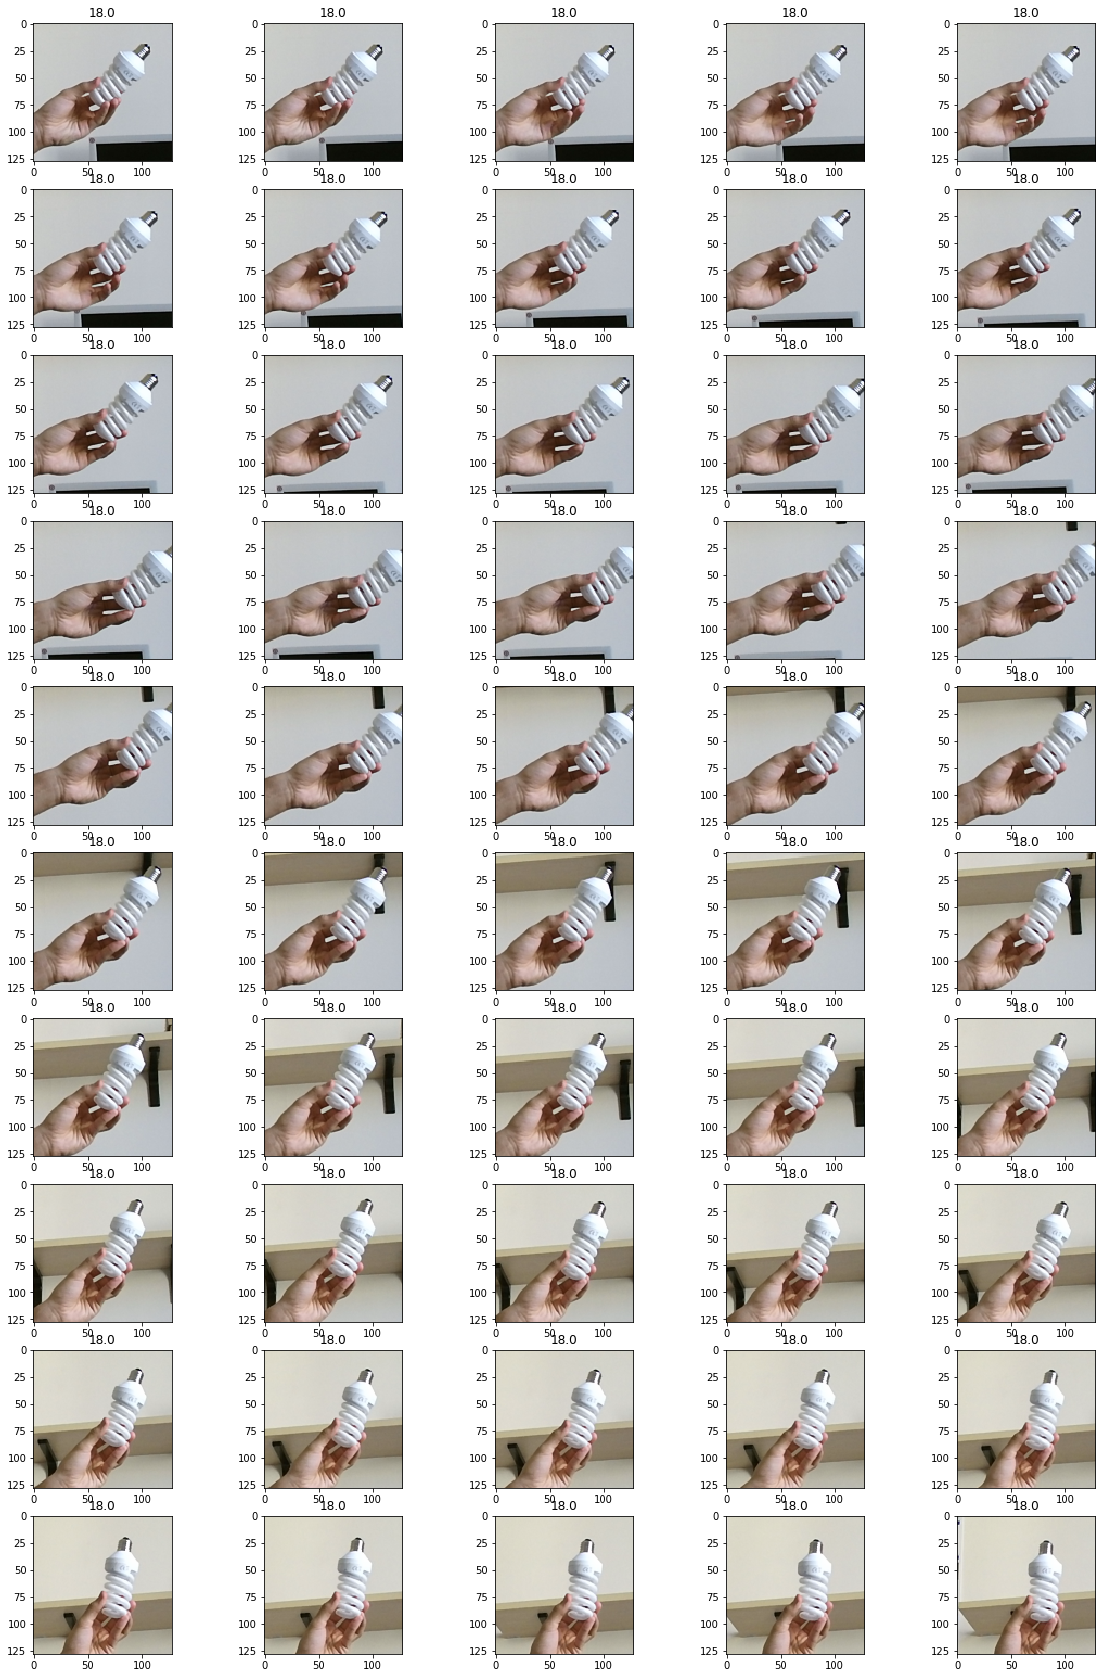

In [75]:
shift = 3000
fig,ax = plt.subplots(figsize=(20,30),ncols = 5,nrows=10)
for i in range(10):
    for j in range(5):
        ax[i,j].imshow(q[i*5+j+shift,:,:,:].astype(np.uint8))
        ax[i,j].set_title(str(train_y[i*5+j+shift]))

10
20


In [7]:
q = np.ones((3,3),dtype=np.float32)

In [12]:
t = torch.as_tensor(q, dtype = torch.float,device=torch.device('cpu'))

In [18]:
yy = t[np.asarray([0,2]),:]


In [21]:
yy.device

device(type='cpu')